### Python Implementation of a Lumped Conceptual HBV model
```python
HBV is a simple conceptual hydrological model that simulates the main hydrological processes related to snow, soil, groundwater, and routing. There are many software packages and off-the-shelf products that implement it.

I’ve been experimenting with the model lately and——in an endeavour to better understand the logic behind it——I decided to implement my own version —— in Python, following an intuitive object-oriented programming approach.

This can be flexibly used for different modelling tasks, but can also be used in a classroom setup —— to explain hydrological concepts (processes, calibration, uncertainty analysis, etc.).

This notebook walk the reader through how to use this model. It follows bulding a model and calibrating it and estimating the uncertainity for a case study.
```

### Getting Started

```python
"""
This module integrates the snow, soil, response and routing routines into a complete
HBV-like hydrological model. It handles parameter management, data reading, model
running, calibration, uncertainity and output visualization.

Usage:
    
    !pip install HBV_Lab

    from HBV_Lab import HBVModel
    model = HBVModel()
    model.load_data("pandas dataframe")
    model.set_parameters(params)
    model.run()
    model.calibrate()
    model.evaluate_uncertainity()
    model.plot_results()
    model.save_results()
    model.save_model("path")
    model.load_model("path")

It is very intiuitive——the model is like an object which has attributes (data, parameters, initial_conditions, etc.) that you can assign and access. The object also performs functions (calibration, uncertainity estimation, save, load, etc.)    

"""

In [ ]:
! pip install HBV_Lab


[notice] A new release of pip is available: 23.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import the Required Functions

In [2]:
from HBV_Lab import HBVModel
import pandas as pd
import matplotlib.pyplot as plt 

### Read the Data into a Pandas Dataframe
```python 
The data we will use includes precipitation, temperature, and potential evapotranspiration on a daily scale. Each variable should be in a column with the same timestep. For the PET column, there is an option to include only 12 values for the monthly means, and the model will extrapolate the daily values.

In [3]:
# Read the dat from excel or csv with pands and save into dataframe
data = pd.read_excel('./data/test_data_2.xlsx') 
data.head(5)

,Date,P,T,Q,PET,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,19810101,0.0,-1.0,0.002,0.05,NaN,NaN,NaN
1,19810102,0.0,-3.6,0.005,0.14,NaN,NaN,HBV_land
2,19810103,0.2,-8.0,0.005,0.46,NaN,NaN,NaN
3,19810104,0.1,-10.3,0.005,1.50,NaN,NaN,NaN
4,19810105,0.0,-15.0,0.005,3.01,NaN,NaN,NaN


### Build an HBV Model
```python 
We will define an HBV model for the calibration period (start_date='1981-01-01', end_date='1983-01-01') 
- start_date < warmup_end < end_date 
- 10 % of the timeseries length will be used as warmup period if warmup_end is not used.
- Use the correct date_format as for your data: '%Y%m%d' for 20250405 '%Y-%m-%d' for 2025-04-05
- If there is an issue with reading the dates, timesteps indexing will be used 

In [4]:
# Initialize the model
model_cal = HBVModel()


# Read the data from pandas df
model_cal.load_data(data=data,
                    date_column='Date',
                    precip_column='P',
                    temp_column='T',
                    pet_column='PET',
                    obs_q_column='Q',
                    date_format='%Y%m%d',
                    start_date='19810101',
                    #warmup_end= '19810701',          
                    end_date='19880101',  ) 

Detected 12 PET values (monthly means), expanding to daily values...
Time step detected: D
No warmup_end specified. Excluding first 10% of data when evaluating——as warmup period.
Loaded data with 2557 time steps, from 1981-01-01 00:00:00 to 1988-01-01 00:00:00


### Define Custom Parameters for the Model 
```python
You can set the parmeters and their ranges, which will later be used for the calibration and the uncertainty analysis. If not assigned, the model will use the default parameters and ranges.

In [15]:
custom_params  = {
            'snow': {
                'TT':    {'min': -2.00000, 'max': 2.00000, 'default': -1.09998}, 
                'CFMAX': {'min': 1.00000,  'max': 6.00000, 'default': 6.00000},
                'SFCF':  {'min': 0.00000,  'max': 1.50000, 'default': 1.03685},
                'CFR':   {'min': 0.00000,  'max': 0.20000, 'default': 0.06868},
                'CWH':   {'min': 0.00000,  'max': 0.20000, 'default': 0.08437}
            },
            'soil': {
                'FC':   {'min': 50.00000,  'max': 500.00000, 'default': 279.73682},
                'LP':   {'min': 0.30000,   'max': 1.00000,   'default': 0.77458},
                'BETA': {'min': 1.00000,   'max': 35.00000,  'default': 3.31552}
            },
            'response': {
                'K0':   {'min': 0.01000,   'max': 0.90000,  'default': 0.11323},
                'K1':   {'min': 0.00500,   'max': 0.50000,  'default': 0.06467},
                'K2':   {'min': 0.00050,   'max': 0.50000,  'default': 0.01832},
                'UZL':  {'min': 5.00000,   'max': 50.00000, 'default': 26.62000},
                'PERC': {'min': 0.003000,   'max': 25.00000, 'default': 0.03000},
                'MAXBAS' :{'min': 1, 'max': 10, 'default': 3}
            }
        }

model_cal.set_parameters(custom_params)  # if not set the default parmeters will be used 

### Set the Initial Conditions
```python
You can set the initial conditions for the model. Default values will be used if not specified.

In [16]:
# Set initial conditions (if not set default values will be used)

model_cal.set_initial_conditions(
                                snowpack=0,          #initial snowpack (mm)
                                liquid_water=0,      # Initial liquid water in snow (mm)
                                soil_moisture= 400,  # Initial soil moisture (mm)
                                upper_storage=10,    # Initial upper zone storage (mm)
                                lower_storage=20, )  # Initial lower zone storage (mm)

Initial conditions updated.


### Run the Model

In [17]:
# Run the model
results = model_cal.run(verbose=True) 

Starting model run for 2557 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 255 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.850
KGE: 0.882
PBIAS: 7.9%
Correlation: 0.948


### Visulaize and Save the Resutls

No warmup_end specified. Excluding first 255 timesteps (10% of data) as warmup period.
Figure saved to ./figures/model_results_before_calibration.png


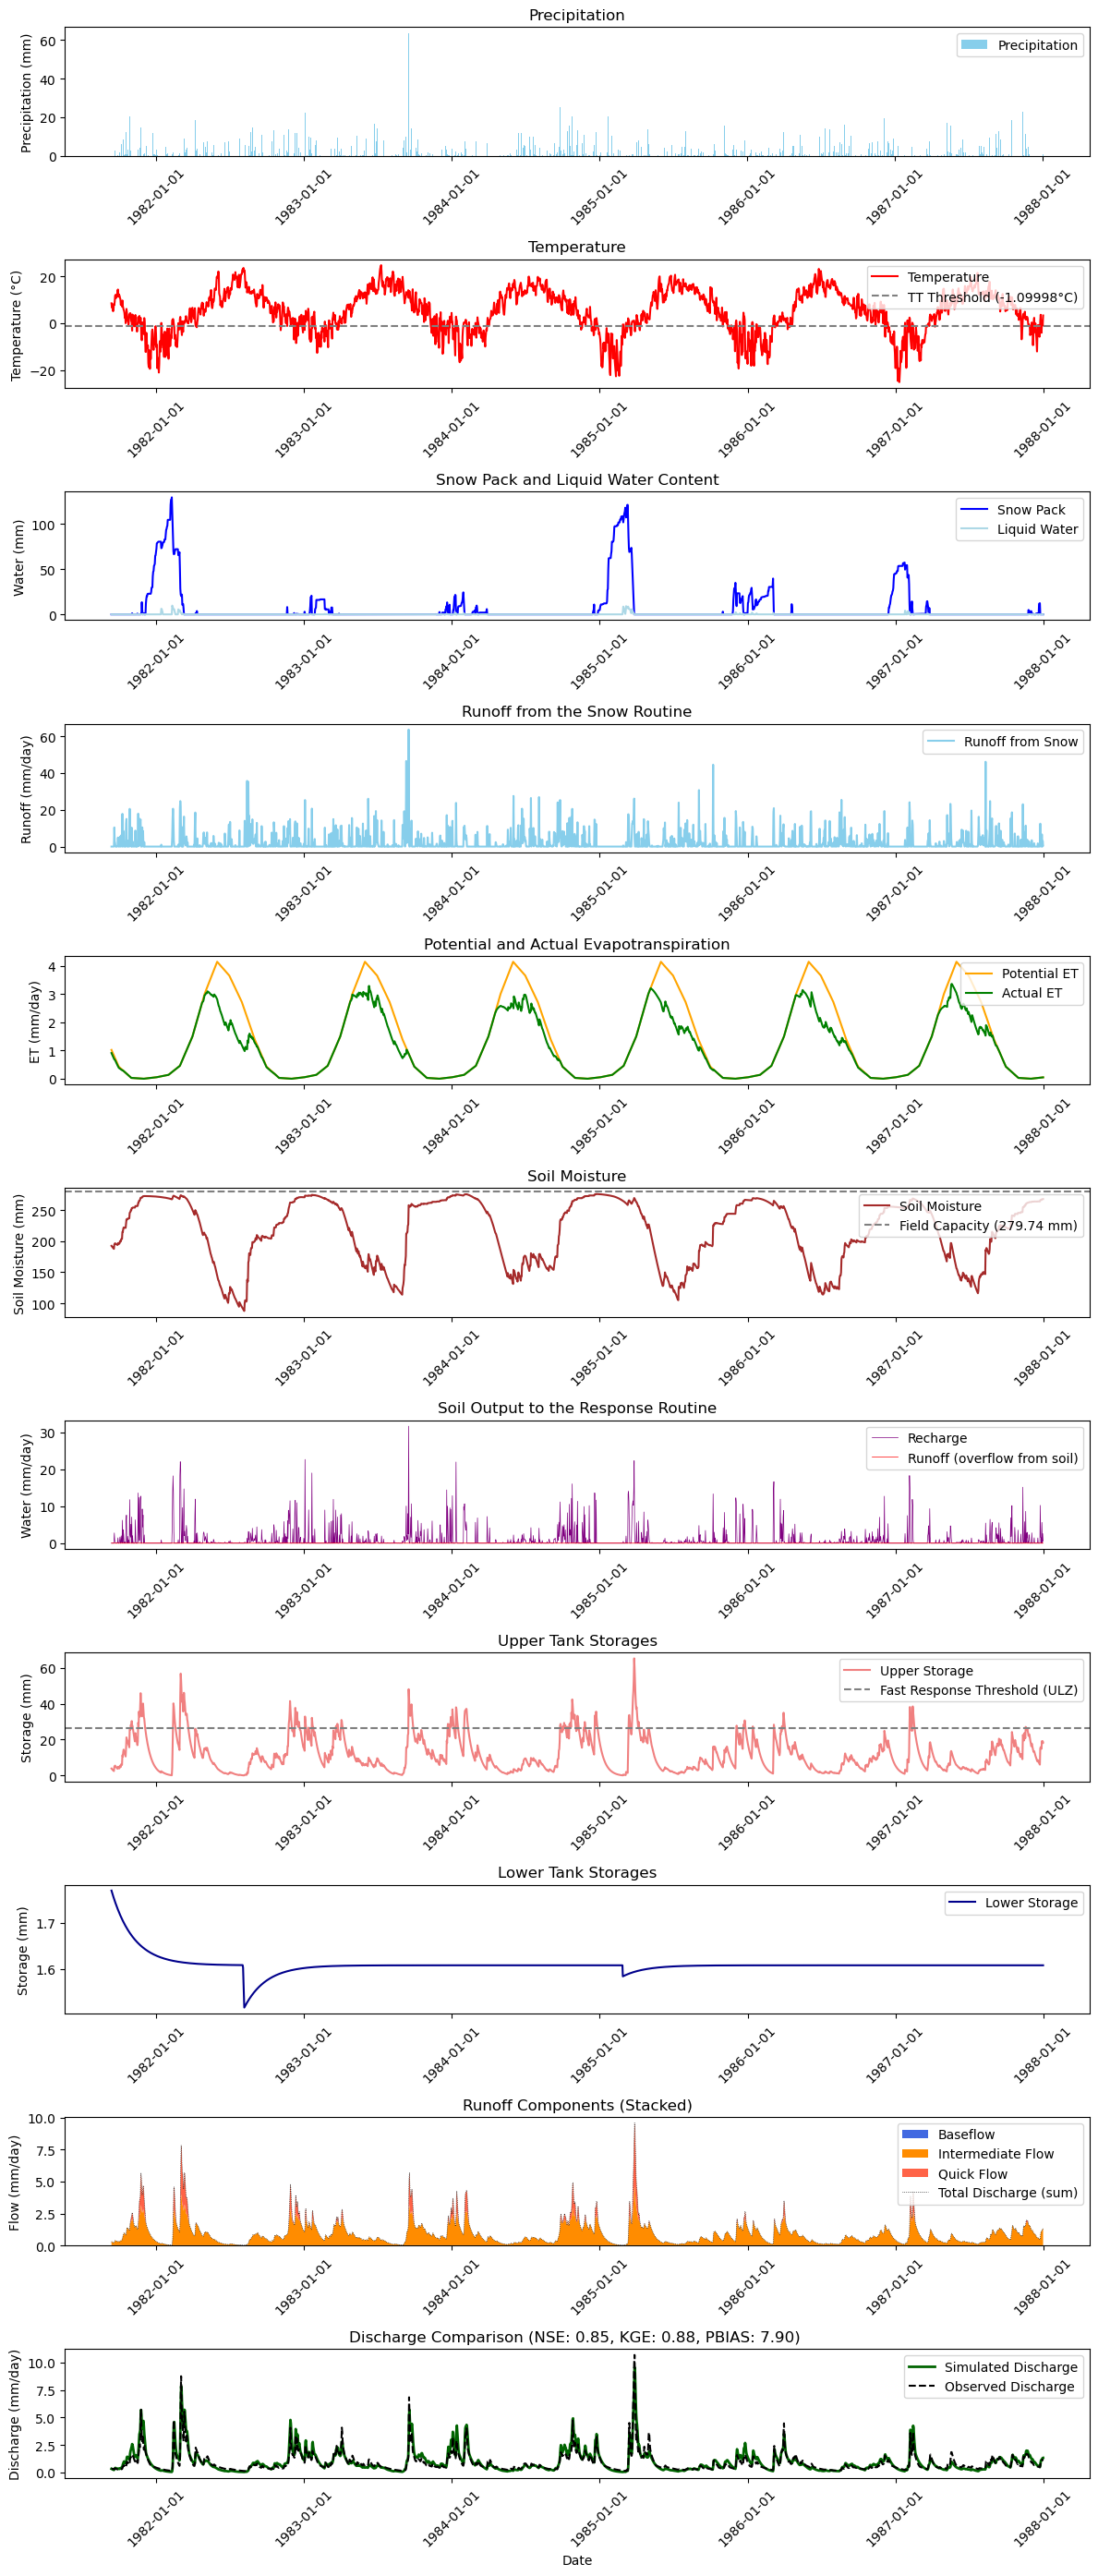

In [18]:
# Visualize results
model_cal.plot_results(output_file='./figures/model_results_before_calibration.png')

# Save results to CSV (optional)
# model_calibration.save_results("./results/hbv_uncalibrated_results.csv")

# Save the model for later use
# model_calibration.save_model('./models/ubnb_uncalibrated')

### Calibrate the Model
```python
You can calibrate the model using an optimization algorithm that tries to find the set of parameters which minimizes the difference between the model's predictions and the observations.

You can also experiment with different optimization algorithms and objective functions

In [22]:
results = model_cal.calibrate(
                                method='SLSQP',      # Optimization algorithm——Options include 'SLSQP', 'L-BFGS-B', 'Nelder-Mead', etc.
                                objective='RMSE',    # Objective function to optimize NSE RMSE KGE 
                                iterations=500000000,     # Maximum iterations
                                verbose= False,         # Print progress
                                plot_results=False     # Plot results after calibration
                            )

# The model now has calibrated parameters
# You can access them via model.params

# You can also access the calibration results
optimized_params = results['parameters']
performance = results['performance']
optimization_details = results['optimization_result']


No warmup_end specified. Excluding first 255 timesteps (10% of data) as warmup period.
Figure saved to ./figures/model_results_after_calibration.png


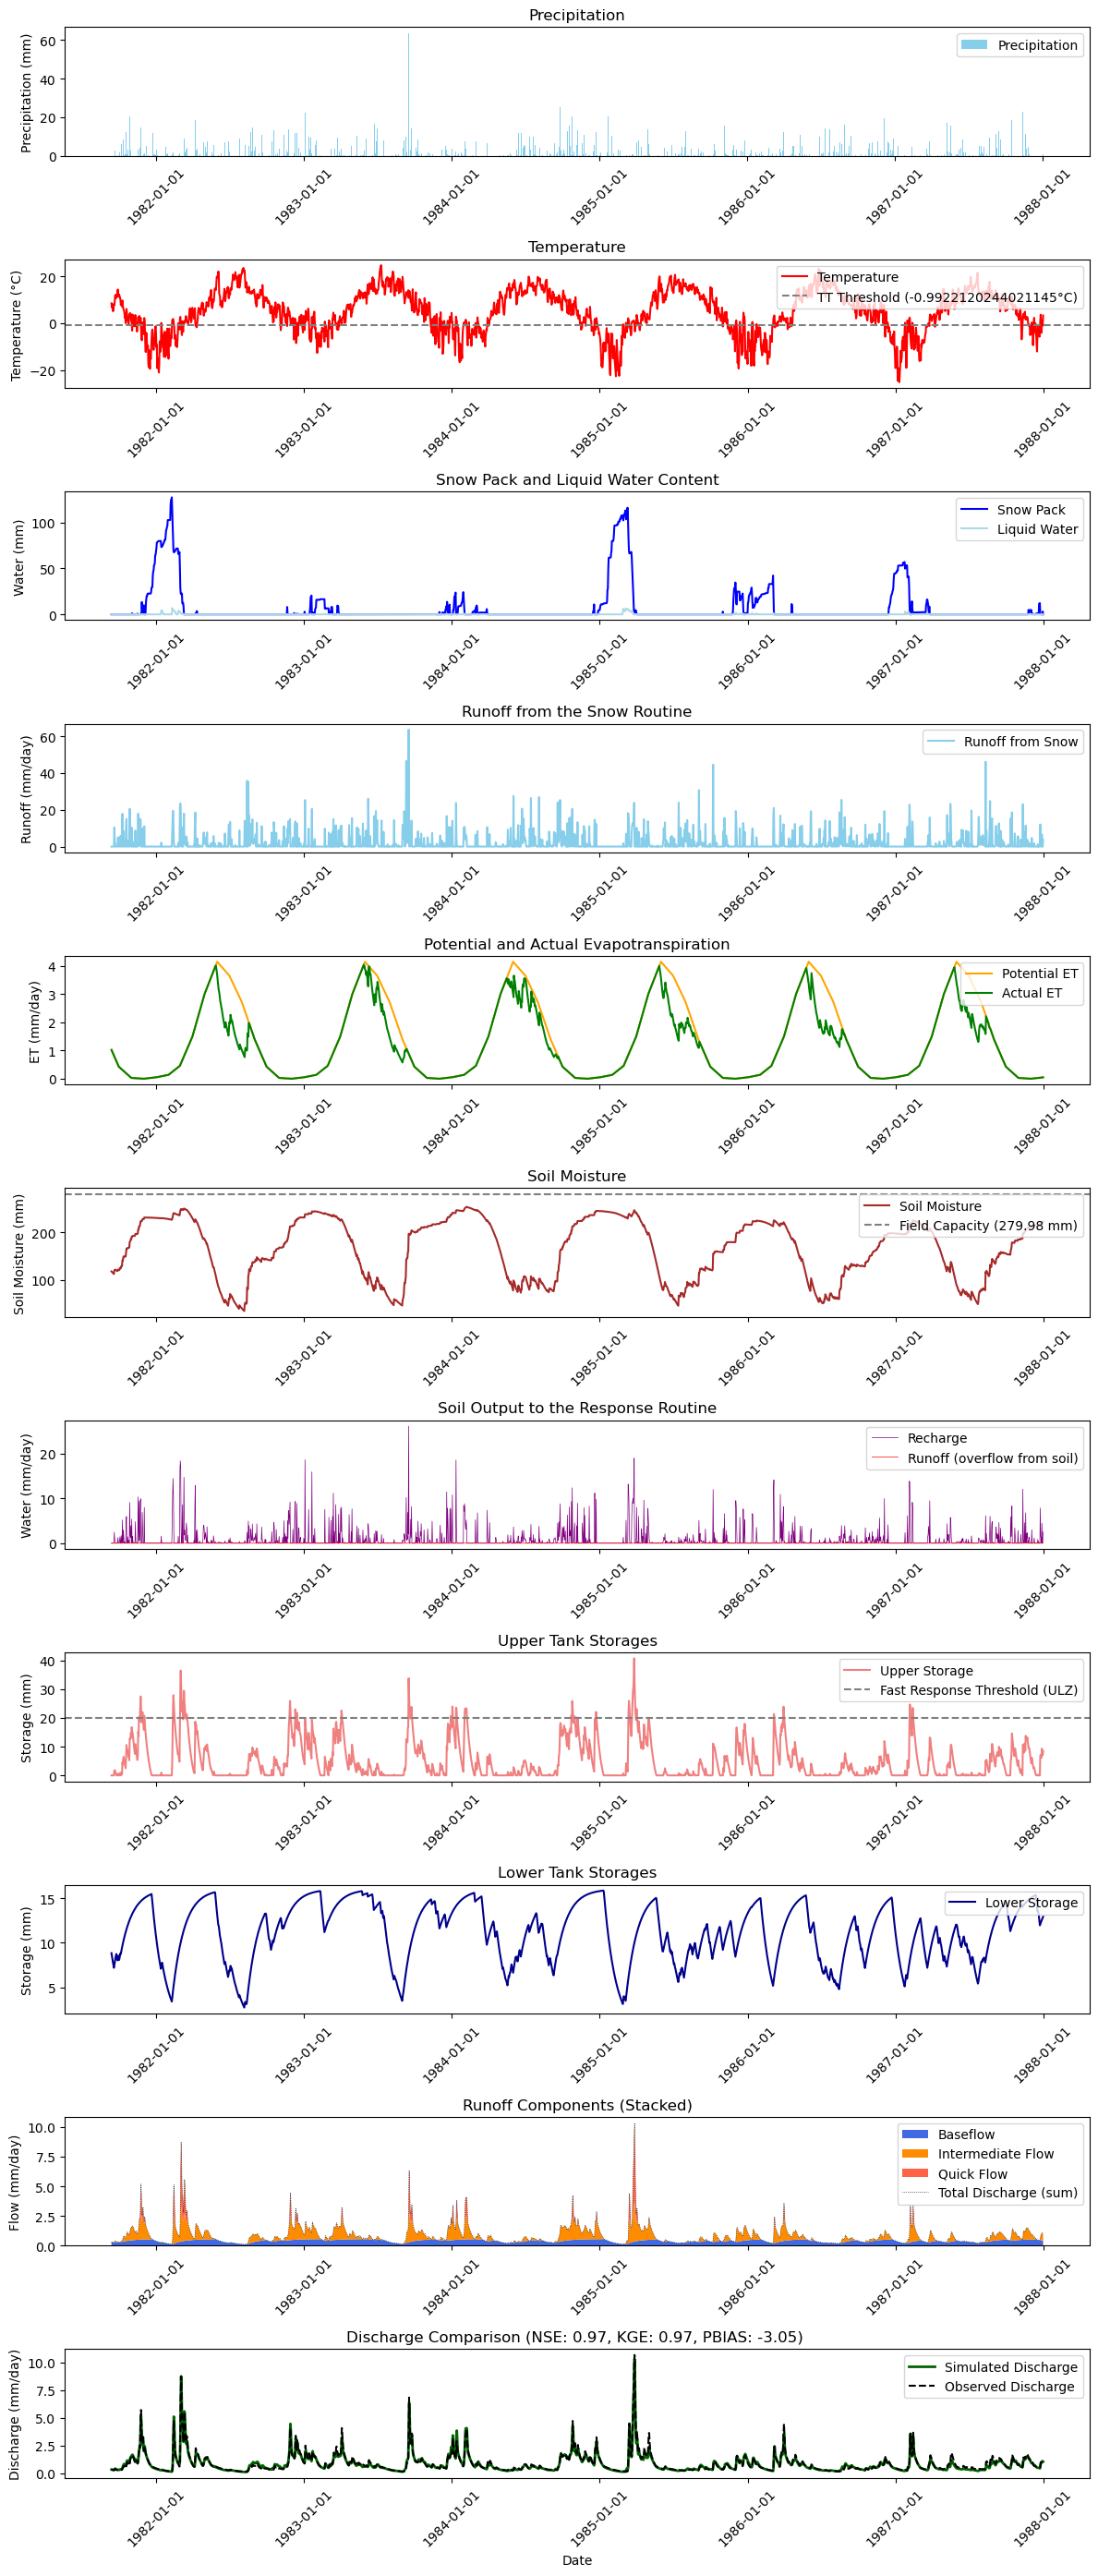

In [23]:
# visualize the results 
model_cal.plot_results(output_file='./figures/model_results_after_calibration.png',show_plots=False)

In [24]:
# inspect the calibrated parameters 
model_cal.params

{'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': -0.9922120244021145},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 6.0},
  'SFCF': {'min': 0.0, 'max': 1.5, 'default': 1.028353669532734},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.022037695950741343},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.05986966756042763}},
 'soil': {'FC': {'min': 50.0, 'max': 500.0, 'default': 279.9793124790277},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 0.39855904552158256},
  'BETA': {'min': 1.0, 'max': 35.0, 'default': 1.590980750826757}},
 'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.24474791330354262},
  'K1': {'min': 0.005, 'max': 0.5, 'default': 0.07188079738410902},
  'K2': {'min': 0.0005, 'max': 0.5, 'default': 0.03352978305834106},
  'UZL': {'min': 5.0, 'max': 50.0, 'default': 19.97376759212773},
  'PERC': {'min': 0.003, 'max': 25.0, 'default': 0.5547174869945726},
  'MAXBAS': {'min': 1, 'max': 10, 'default': 3.0}}}

In [31]:
# Some useful helper functions
#model.plot_results(output_file='./figures/model_results_after_calibratoin.png')
model_cal.save_results(output_file='./results/results_after_calibration.csv')
model_cal.save_model(output_path='./models/model_calibrated')

Results saved to ./results/results_after_calibration.csv
Model saved to ./models/model_calibrated


### Testing the Model
```python
Now We shall test the Model for the Validation Period (start_date='1988-01-01', end_date='1991-12-31'). We will leave 10% for the warmup period.


In [26]:
# Initialize a model for the validation period 
model_val = HBVModel()

# Read the data from pandas df——with the validation dates instead
model_val.load_data(data=data,
                    date_column='Date',
                    precip_column='P',
                    temp_column='T',
                    pet_column='PET',
                    obs_q_column='Q',
                    date_format='%Y%m%d',
                    start_date='19880101', 
                    warmup_end= None,         
                    end_date= '19911231',  )      # it is enough to use the start date 
                                                  # the model will automatically continue till the end 

Detected 12 PET values (monthly means), expanding to daily values...
Time step detected: D
No warmup_end specified. Excluding first 10% of data when evaluating——as warmup period.
Loaded data with 1461 time steps, from 1988-01-01 00:00:00 to 1991-12-31 00:00:00


In [27]:
# set the calibrated parameters from the calibrated model
calibrated_parameters = model_cal.params

# if you have the calibrated model saved you can load it and get its parameters 
# model_cal = HBVModel.load_model("./models/model_calibrated")
# calibrated_parameters = model_cal.params

model_val.set_parameters(calibrated_parameters)

In [28]:
# Set initial conditions and run the model

model_val.set_initial_conditions(
                                snowpack=0,  #initial snowpack (mm)
                                liquid_water=0,    # Initial liquid water in snow (mm)
                                soil_moisture= 400,  # Initial soil moisture (mm)
                                upper_storage=10,   # Initial upper zone storage (mm)
                                lower_storage= 200, ) # Initial lower zone storage (mm)

results= model_val.run(verbose=True)   # run the validation model

Initial conditions updated.
Starting model run for 1461 time steps...
Applying MAXBAS routing with n=3 time steps
Model run completed successfully!
No warmup_end specified. Excluding first 146 timesteps (10% of data) as warmup period.
Performance metrics calculated:
NSE: 0.933
KGE: 0.865
PBIAS: 3.4%
Correlation: 0.969


No warmup_end specified. Excluding first 146 timesteps (10% of data) as warmup period.
Figure saved to ./figures/model_results_validation.png


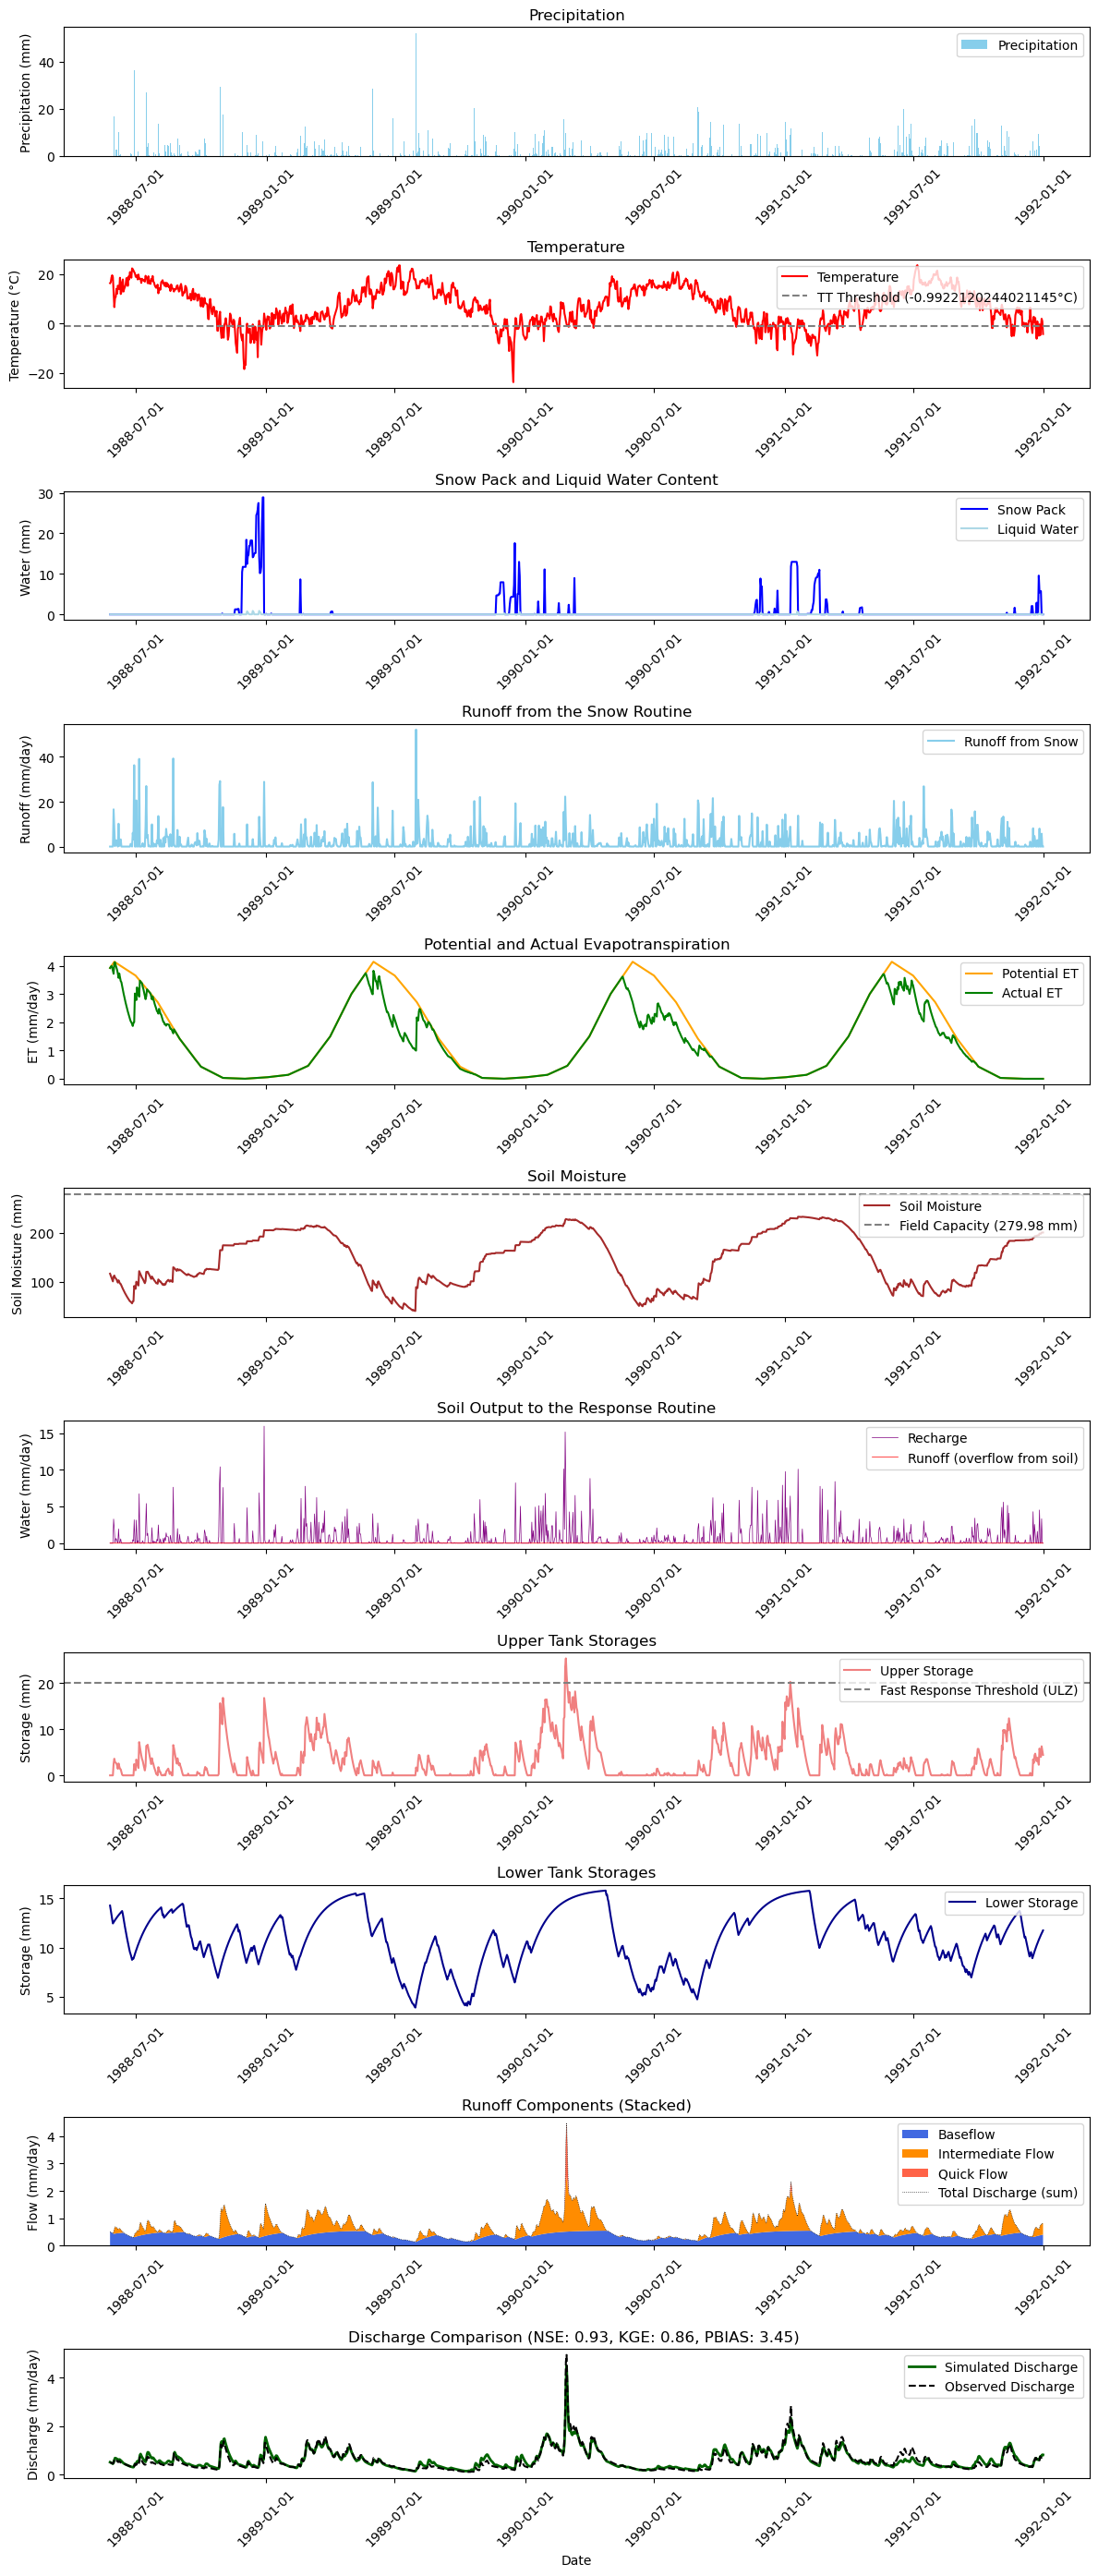

In [29]:
model_val.plot_results(output_file='./figures/model_results_validation.png')

In [32]:
model_val.save_results(output_file='./results/results_validation.csv')

Results saved to ./results/results_validation.csv


### Evaluating the Parameters' Uncertainty 
```python
Now we shall do the uncertainty analysis following the Monte Carlo method. There are different ways you can approach this.

Here, and since we have already done the calibration, we first narrow the ranges around the calibrated values and then sample from the narrowed ranges.

We sample uniformly from the ranges n number of times and run the model n times with these samples. The best 10 runs are saved and used for estimating the uncertainty. We show the best run among the samples and also show the calibrated run along with the 95% prediction interval obtained from the 10 runs.

You can also use the Monte Carlo method directly for calibrating the model.

  0%|          | 0/3000 [00:00<?, ?it/s]

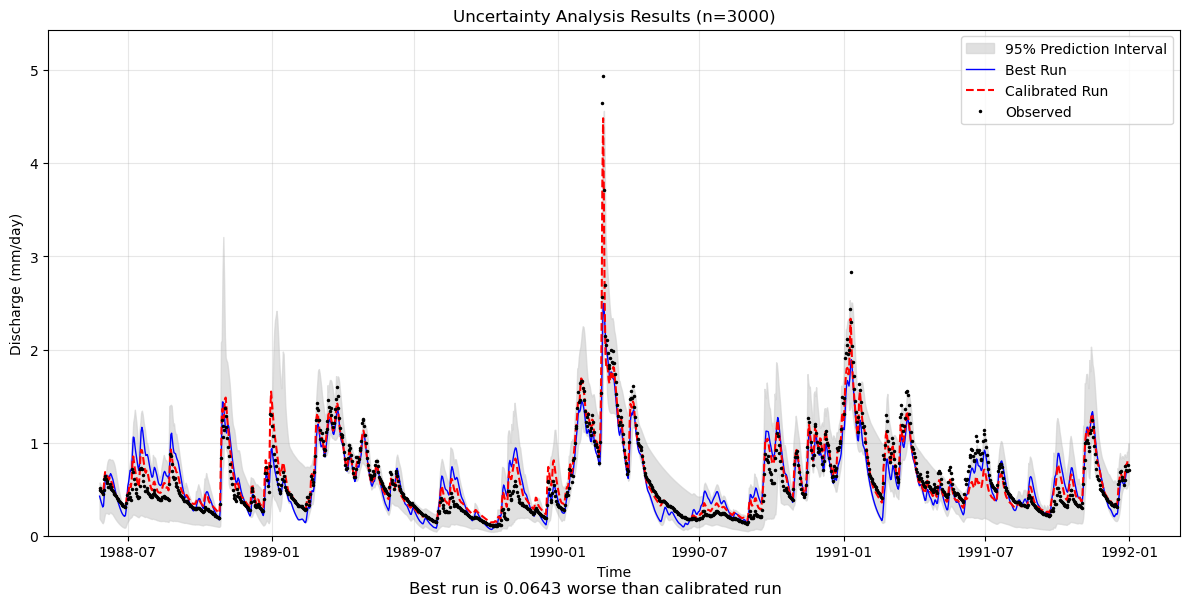

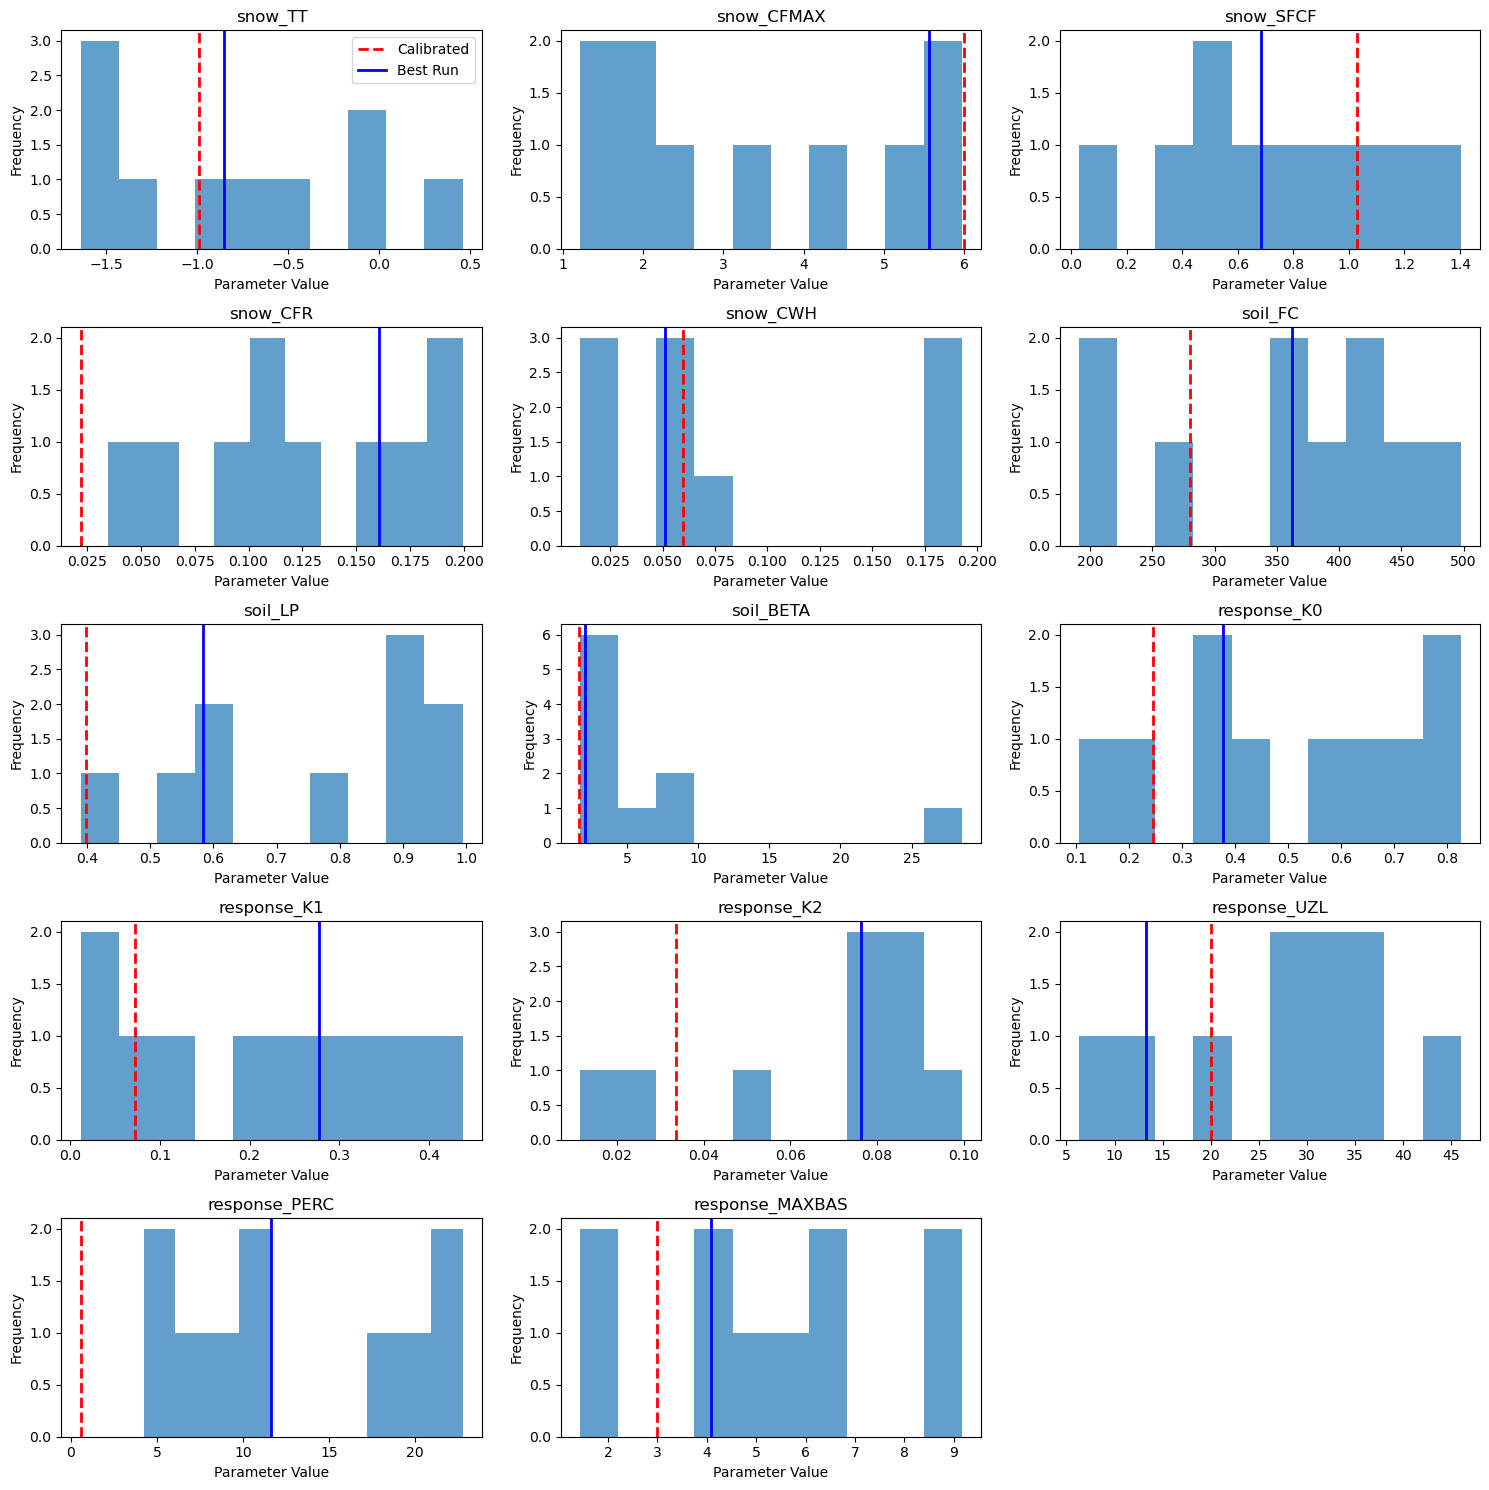

In [30]:
# Then run uncertainty analysis
uncertainty_results = model_val.evaluate_uncertainty(
                                                    n_runs=3000,            # Number of Monte Carlo samples
                                                    objective='KGE',        # Performance metric to use for ranking the model runs
                                                    save_best= 10,           # Number of best runs to save
                                                    plot_results=True,      # Generate visualization
                                                    verbose=False,           # Print progress information
                                                    seed=42 ,                # Optional random seed for reproducibility
                                                    narrow_percent= 1,       # percentage of the original range length around the calibrated value 1 for 100%
                                                                             # here I used the full range       
                                                )

 The data used in this case study was downladed from [here](https://www.geo.uzh.ch/en/units/h2k/Services/HBV-Model.html)